# 0. Предварительная подготовка

In [21]:
import os
import pandas as pd
import requests
import textwrap
from transformers import pipeline
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# Фиксируем random state
rstate = 42

In [23]:
DATA_URL = "https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz"
DATA_PATH = "lenta-ru-news.csv.gz"

if not os.path.exists(DATA_PATH):
    print(f"Файл {DATA_PATH} не найден, скачиваю из {DATA_URL}")
    response = requests.get(DATA_URL, stream=True, timeout=60)
    if response.status_code != 200:
        raise RuntimeError(f"Не удалось скачать датасет: HTTP {response.status_code}")
    with open(DATA_PATH, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print("Загрузка завершена")
else:
    print(f"Используем локальный файл {DATA_PATH}")

df = pd.read_csv(DATA_PATH)

# Удаляем строки с отсутствующим текстом
df.dropna(subset=["text"], inplace=True)

# Оставим только нужные колонки
df = df[["title", "text", "topic"]].copy()
print(df.info())
print()
print(df.head())

Используем локальный файл lenta-ru-news.csv.gz
<class 'pandas.core.frame.DataFrame'>
Index: 739346 entries, 0 to 739350
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   739346 non-null  object
 1   text    739346 non-null  object
 2   topic   739143 non-null  object
dtypes: object(3)
memory usage: 22.6+ MB
None

                                               title  \
0  Названы регионы России с самой высокой смертно...   
1  Австрия не представила доказательств вины росс...   
2       Обнаружено самое счастливое место на планете   
3  В США раскрыли сумму расходов на расследование...   
4  Хакеры рассказали о планах Великобритании зами...   

                                                text        topic  
0  Вице-премьер по социальным вопросам Татьяна Го...       Россия  
1  Австрийские правоохранительные органы не предс...        Спорт  
2  Сотрудники социальной сети Instagram проанализ...  Путешествия  
3  С на

# 1. Hugging Face и pipeline API

In [24]:
# Для проверки выберем 5 новостей
indices_to_summarize = [1, 40, 100, 500, 1000]
texts_from_dataset = df.loc[indices_to_summarize]["text"].tolist()

# Добавим 3 примера out-of-domain

# Стихи
poem = """Ночь, улица, фонарь, аптека,
          Бессмысленный и тусклый свет.
          Живи еще хоть четверть века -
          Всё будет так. Исхода нет.
          
          Умрешь - начнешь опять сначала
          И повторится всё, как встарь:
          Ночь, ледяная рябь канала,
          Аптека, улица, фонарь."""

# Переписка
texting = """А: Привет! Ты вчера до скольки сидел?
             Б: Привет. Почти до двух ночи.
             А: Жесть.
             Б: Не то слово. Зато, кажется, я нашел тот баг с авторизацией.
             А: Серьезно? Который два дня искали?
             Б: Да.
             А: И что там было?
             Б: Банально. В одном из env-файлов не хватало ключа.
             А: В смысле?
             Б: Ну, в .env.local он был, а в .env.prod – нет.
             А: И деплой шел с prod-конфигом?
             Б: Именно. А локально у всех все работало.
             А: Классика. Я же говорил, что надо конфиги проверить.
             Б: Говорил. Но кто ж думал, что так тупо."""

# Текст объявления с Авито (авторская орфография и пунктуация)
short_text = "Разминочный костюм BJORN DAEHLIE ,состояние новой вещи,без каких -либо следов износа.По бирке xl,но в реале L,замеры на фото,ориентируйтесь по ним.Произведено в России,но качества материала,пошива и лекала на высоте...Красивый яркий комбинезон."

texts_from_dataset.extend([poem, texting, short_text])

In [25]:
summarizer = pipeline("summarization", model="IlyaGusev/rut5_base_sum_gazeta")


# Функция для форматирования вывода 4 строки максимум по 120 символов
def wrapper(text: str) -> str:
    return textwrap.fill(text, width=120, max_lines=4, placeholder="...")


for i, text in enumerate(texts_from_dataset, start=1):
    # Генерируем саммари
    summary = summarizer(text, max_length=300, min_length=30, do_sample=False)

    # Вывод в читаемом формате
    print("\n" + "=" * 120 + "\n")
    print(f"--- Пример № {i} ---")
    print(f"Оригинал:\n{wrapper(text)}")
    print("\n")
    print(f"Суммаризация:\n{wrapper(summary[0]['summary_text'])}")
    print(f"\nИзменение размера: {len(text)} -> {len(summary[0]['summary_text'])}")

Device set to use cuda:0




--- Пример № 1 ---
Оригинал:
Австрийские правоохранительные органы не представили доказательств нарушения российскими биатлонистами антидопинговых
правил. Об этом сообщил посол России в Вене Дмитрий Любинский по итогам встречи уполномоченного адвоката дипмиссии с
представителями прокуратуры страны, передает ТАСС. «Действует презумпция невиновности. Каких-либо ограничений свободы
передвижения для команды нет», — добавили в посольстве. Международный союз биатлонистов (IBU) также не будет...


Суммаризация:
Австрийские правоохранительные органы не представили доказательств нарушения российскими биатлонистами антидопинговых
правил. Международный союз биатлонистов (IBU) также не будет применять санкции к российским биатлонистам. Международный
союз биатлонистов (IBU) также не будет применять санкции к российским биатлонистам.

Изменение размера: 1072 -> 321


--- Пример № 2 ---
Оригинал:
В Московском районе Санкт-Петербурга на продажу выставлена доля в 58-комнатной квартире. Об этом в свое

Your max_length is set to 300, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)




--- Пример № 5 ---
Оригинал:
Российский скелетонист Никита Трегубов победил на этапе Кубка мира в Латвии. Он обошел хозяина трассы Мартинса Дукурса,
сообщает ТАСС. По итогам двух заездов 23-летний россиянин показал результат 1 минута 41,87 секунды. Дукурс занял второе
место и отстал на 0,37 секунды. Третьим стал действующий обладатель Кубка мира южнокореец Юн Сон Бин (плюс 0,53). Для
Трегубова эта победа стала первой в карьере на этапах Кубка мира. На Олимпиаде 2018 года он завоевал серебряную...


Суммаризация:
Российский скелетонист Никита Трегубов победил на этапе Кубка мира в Латвии. 23-летний россиянин показал результат 1
минута 41,87 секунды и отстал на 0,37 секунды. Третьим стал действующий обладатель Кубка мира южнокореец Юн Сон Бин
(плюс 0,53). Третьим стал действующий обладатель Кубка мира южнокореец Юн Сон Бин (плюс 0,53).

Изменение размера: 1064 -> 327


Your max_length is set to 300, but your input_length is only 205. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=102)




--- Пример № 6 ---
Оригинал:
Ночь, улица, фонарь, аптека,           Бессмысленный и тусклый свет.           Живи еще хоть четверть века -
Всё будет так. Исхода нет.            Умрешь - начнешь опять сначала           И повторится всё, как встарь:
Ночь, ледяная рябь канала,           Аптека, улица, фонарь.


Суммаризация:
Ночь, улица, фонарь, аптека, Бессмысленный и тусклый свет. Живи еще четверть века - Всё будет так. Исхода нет. Исхода
нет. Исхода нет. Исхода нет. Исхода нет. Исхода нет. Исхода нет. Исхода нет. Исхода нет. Исхода нет. Исхода нет. Исхода
нет. Исхода нет. Исхода нет. Исхода нет. Исхода нет. Исхода нет. Исхода нет. Исхода нет.

Изменение размера: 297 -> 326


Your max_length is set to 300, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)




--- Пример № 7 ---
Оригинал:
А: Привет! Ты вчера до скольки сидел?              Б: Привет. Почти до двух ночи.              А: Жесть.              Б:
Не то слово. Зато, кажется, я нашел тот баг с авторизацией.              А: Серьезно? Который два дня искали?
Б: Да.              А: И что там было?              Б: Банально. В одном из env-файлов не хватало ключа.              А:
В смысле?              Б: Ну, в .env.local он был, а в .env.prod – нет.              А: И деплой шел с prod-конфигом?...


Суммаризация:
Вчера я нашел тот баг с авторизацией, который нашел я.env.local, а в одном из файлов не хватало ключа, а в одном из
файлов не хватало ключа. А в одном из файлов не хватало ключа, а в одном из env-файлов не хватало ключа.

Изменение размера: 661 -> 220


--- Пример № 8 ---
Оригинал:
Разминочный костюм BJORN DAEHLIE ,состояние новой вещи,без каких -либо следов износа.По бирке xl,но в реале L,замеры на
фото,ориентируйтесь по ним.Произведено в России,но качества материала,пошива 

## Выводы

Тестирование модели `IlyaGusev/rut5_base_sum_gazeta` показало:

1.  **Новости (целевой домен):**
    * Модель хорошо справляется с новостными статьями, корректно передавая их суть и ключевые факты.
    * Основной недостаток — периодические повторы предложений в сгенерированных саммари.

2.  **Другие домены (out-of-domain):**
    * Модель не справляется с нецелевыми форматами, что ожидаемо, так как она обучалась на новостях.
    * **Стихи:** Генерируется набор повторяющихся фраз.
    * **Диалог:** Попытка связного текста приводит к бессмыслице и искажению фактов.
    * **Объявление:** Короткий текст обрабатывается неверно, с генерацией нелогичных фрагментов.

# 2. Анализ эмбеддингов трансформерных моделей

In [ ]:
# отключаем форматтер для читаемости inline комментариев
# fmt: off

# Предложения для обработки
# Три связанные пары и четыре предложения без пар
sentences = [
    "Автомобиль едет быстро.",                      # 0  - Пара №1
    "Машина мчится на большой скорости.",           # 1  - Пара №1
    "Сегодня хорошая погода.",                      # 2  - Пара №2
    "На улице отличный денек.",                     # 3  - Пара №2
    "Королева была недовольна.",                    # 4  - Пара №3
    "Ее величество пребывала в дурном настроении.", # 5  - Пара №3
    "Космонавты готовятся к полету на Марс.",       # 6  - без пары
    "В лесу выросли грибы.",                        # 7  - без пары
    "Этот рецепт пирога очень простой.",            # 8  - без пары
    "Квантовая физика - сложная наука.",            # 9  - без пары
]

In [ ]:
# Обертка для удобного расчета косинусного сходства между двумя векторами
def get_cos_sim(vec1, vec2):
    return cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0, 0]

## 2.1 Bert-based модель

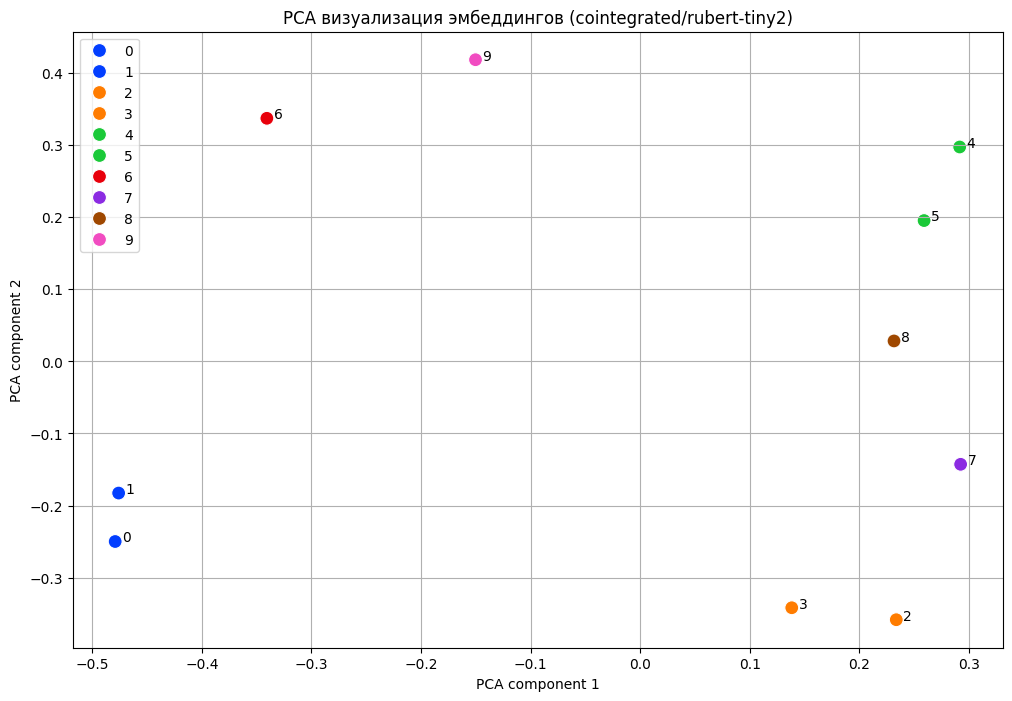

Косинусное сходство для пар:
Пара №1 (0-1) ('Автомобиль' vs 'Машина'): 0.8338
Пара №2 (2-3) ('Погода' vs 'Денек'): 0.6983
Пара №3 (4-5) ('Королева' vs 'Величество'): 0.6825

Косинусное сходство для не связанных предложений:
'Автомобиль'(0) vs 'Квантовая физика'(9): 0.4167
'Погода'(2) vs 'Грибы'(7): 0.5388


In [ ]:
bert_model_name = "cointegrated/rubert-tiny2"
bert_model = SentenceTransformer(bert_model_name)
bert_embeddings = bert_model.encode(sentences)

# Визуализация с помощью PCA
pca = PCA(n_components=2, random_state=rstate)
bert_embeddings_2d = pca.fit_transform(bert_embeddings)

plt.figure(figsize=(12, 8))
# Назначим одинаковые цвета для пар синонимов, чтобы их было легче отличить
palette = sns.color_palette("bright", 10)
colors = [
    palette[0],
    palette[0],
    palette[1],
    palette[1],
    palette[2],
    palette[2],
    palette[3],
    palette[4],
    palette[5],
    palette[6],
]

sns.scatterplot(
    x=bert_embeddings_2d[:, 0],
    y=bert_embeddings_2d[:, 1],
    hue=[str(i) for i in range(len(sentences))],
    palette=colors,
    legend="full",
    s=100,
)

for i, _ in enumerate(sentences):
    plt.annotate(i, (bert_embeddings_2d[i, 0], bert_embeddings_2d[i, 1]), textcoords="offset points", xytext=(5, 0))

plt.title(f"PCA визуализация эмбеддингов ({bert_model_name})")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.grid(True)
plt.show()

print("Косинусное сходство для пар:")
print(f"Пара №1 (0-1) ('Автомобиль' vs 'Машина'): {get_cos_sim(bert_embeddings[0], bert_embeddings[1]):.4f}")
print(f"Пара №2 (2-3) ('Погода' vs 'Денек'): {get_cos_sim(bert_embeddings[2], bert_embeddings[3]):.4f}")
print(f"Пара №3 (4-5) ('Королева' vs 'Величество'): {get_cos_sim(bert_embeddings[4], bert_embeddings[5]):.4f}")

print("\nКосинусное сходство для не связанных предложений:")
print(f"'Автомобиль'(0) vs 'Квантовая физика'(9): {get_cos_sim(bert_embeddings[0], bert_embeddings[9]):.4f}")
print(f"'Погода'(2) vs 'Грибы'(7): {get_cos_sim(bert_embeddings[2], bert_embeddings[7]):.4f}")

## GPT-based модель

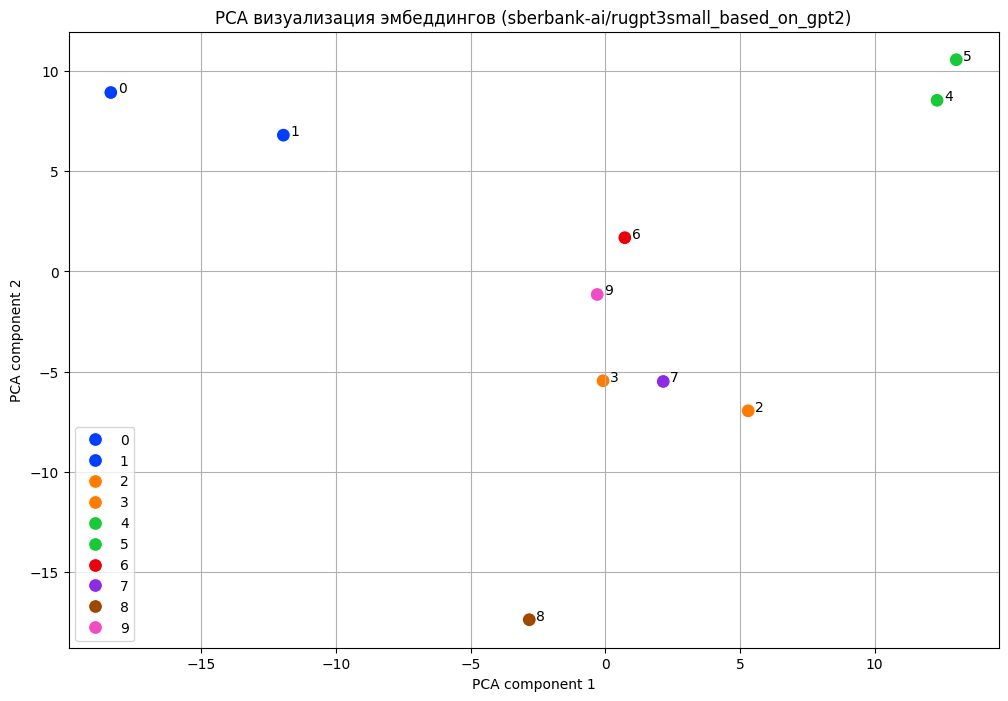

Косинусное сходство для пар:
Пара №1 (0-1) ('Автомобиль' vs 'Машина'): 0.6386
Пара №2 (2-3) ('Погода' vs 'Денек'): 0.6216
Пара №3 (4-5) ('Королева' vs 'Величество'): 0.5629

Косинусное сходство для не связанных предложений:
'Автомобиль'(0) vs 'Квантовая физика'(9): 0.3851
'Погода'(2) vs 'Грибы'(7): 0.4756


In [34]:
gpt_model_name = "sberbank-ai/rugpt3small_based_on_gpt2"
gpt_tokenizer = AutoTokenizer.from_pretrained(gpt_model_name)
gpt_model = AutoModel.from_pretrained(gpt_model_name)


# Функция для получения эмбеддингов из GPT
def get_gpt_embeddings(sentences, tokenizer, model):
    # Токенизация
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

    # Получение эмбеддингов
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Усреднение токенов для получения эмбеддинга предложения (mean pooling)
    attention_mask = encoded_input["attention_mask"]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(model_output.last_hidden_state.size()).float()
    sum_embeddings = torch.sum(model_output.last_hidden_state * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    return (sum_embeddings / sum_mask).numpy()


# Запуск генерации эмбеддингов
gpt_embeddings = get_gpt_embeddings(sentences, gpt_tokenizer, gpt_model)

# Визуализация с помощью PCA
pca = PCA(n_components=2, random_state=rstate)
gpt_embeddings_2d = pca.fit_transform(gpt_embeddings)

plt.figure(figsize=(12, 8))
palette = sns.color_palette("bright", 10)
colors = [
    palette[0],
    palette[0],
    palette[1],
    palette[1],
    palette[2],
    palette[2],
    palette[3],
    palette[4],
    palette[5],
    palette[6],
]
sns.scatterplot(
    x=gpt_embeddings_2d[:, 0],
    y=gpt_embeddings_2d[:, 1],
    hue=[str(i) for i in range(len(sentences))],
    palette=colors,
    legend="full",
    s=100,
)
for i, _ in enumerate(sentences):
    plt.annotate(i, (gpt_embeddings_2d[i, 0], gpt_embeddings_2d[i, 1]), textcoords="offset points", xytext=(5, 0))
plt.title(f"PCA визуализация эмбеддингов ({gpt_model_name})")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.grid(True)
plt.show()

# --- Расчет косинусного сходства ---
print("Косинусное сходство для пар:")
print(f"Пара №1 (0-1) ('Автомобиль' vs 'Машина'): {get_cos_sim(gpt_embeddings[0], gpt_embeddings[1]):.4f}")
print(f"Пара №2 (2-3) ('Погода' vs 'Денек'): {get_cos_sim(gpt_embeddings[2], gpt_embeddings[3]):.4f}")
print(f"Пара №3 (4-5) ('Королева' vs 'Величество'): {get_cos_sim(gpt_embeddings[4], gpt_embeddings[5]):.4f}")

print("\nКосинусное сходство для не связанных предложений:")
print(f"'Автомобиль'(0) vs 'Квантовая физика'(9): {get_cos_sim(gpt_embeddings[0], gpt_embeddings[9]):.4f}")
print(f"'Погода'(2) vs 'Грибы'(7): {get_cos_sim(gpt_embeddings[2], gpt_embeddings[7]):.4f}")

## Выводы

Сравнивались две модели: `cointegrated/rubert-tiny2` (BERT) и `sberbank-ai/rugpt3small_based_on_gpt2` (GPT). Для GPT эмбеддинг предложения рассчитывался как среднее его токенов.

1.  **Визуализация (PCA):**
    * **Ограничение PCA**: Агрессивное снижение размерности (до 2D) на малой выборке может искажать картину, поэтому выводы на основе визуализации предварительны.
    * **BERT**: Показал четкую кластеризацию. Синонимичные пары расположены близко, предложения с разным смыслом — далеко.
    * **GPT**: Структура менее четкая. Синонимы сгруппированы, однако некоторые несинонимичные пары также расположены близко к ним и друг к другу.

2.  **Косинусное сходство:**
    * **BERT**: Высокое сходство для синонимов (~0.7-0.8) и низкое для разных по смыслу предложений.
    * **GPT**: Сходство для синонимов ниже, чем у BERT. Разница (дельта) между средним сходством синонимов и не-синонимов также меньше, что указывает на худшую различительную способность.

**Общий вывод:** Обе модели формируют ожидаемые эмбеддинги (близкие для схожих, далекие для различных). Несмотря на ограничения (малая выборка, агрессивное PCA), эксперимент подтверждает, что BERT-архитектуры (энкодеры) лучше подходят для задач семантического сравнения, чем GPT-архитектуры (декодеры), оптимизированные для генерации текста.